<a href="https://colab.research.google.com/github/praveenhosdrug123/Keras_hybrid_customer_lifetime_value/blob/main/Keras_Tutorial_Customer_Lifetime_Value.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning for Customer Lifetime Value Prediction

**Author:** [Praveen Hosdrug](https://www.linkedin.com/in/praveenhosdrug/)<br>
**Date created:** 2024/11/23<br>
**Last modified:**

**Description:** This tutorial implements a LSTM/Transformer based architecture for predicting customer lifetime value.
The model demonstrates strong performance on multi-step CLV forecasting.

## Introduction
Traditional approaches often treat each customer's purchase history as an isolated timeseries, much like how basic forecasting models handle independent sequences. However, customer behavior exists within a complex network of interactions, influenced by various factors such as seasonal patterns, demographic similarities, and purchase dependencies - similar to how we observe interconnected patterns in financial and human activity data.

This approach leverages the power of recurrent neural networks and transformer architecture, which maintain state between inputs and can effectively process sequential customer interaction data. This is particularly valuable because, like other predictive tasks, CLV prediction requires understanding both historical patterns and temporal dependencies in customer behavior.

For the purpose of the tutorial; we will be using the UK Retail [Dataset](https://archive.ics.uci.edu/dataset/352/online+retail).
You can install it via the following command: `pip install ucimlrepo

This example requires access to the transformer encoder layer in keras_hub package. You can install it via the following command `pip install keras_hub





##Setting up Libraries for the Deep Learning Project

In [ ]:
# Set Keras backend
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

# Core data processing and numerical libraries
import numpy as np
import pandas as pd
from typing import Dict
import tensorflow as tf

# For reproducibility across modelling
def set_seeds(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.keras.utils.set_random_seed(seed)

# Visualization
import matplotlib.pyplot as plt

# Keras imports
import keras
from keras import layers
from keras.models import Model, Sequential
from keras.layers import (
    Input, Dense, Conv1D, GRU, LSTM,
    Dropout, MaxPooling1D, GlobalAveragePooling1D,
    SpatialDropout1D, BatchNormalization, Add,
    Embedding, Flatten, RepeatVector, Concatenate, Dropout,
    Bidirectional

)
from keras_hub.layers import TransformerEncoder
from keras.callbacks import EarlyStopping,ReduceLROnPlateau

# Data preprocessing
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

# Model visualization
from keras.utils import plot_model,model_to_dot
from IPython.display import display
from graphviz import Source

# UK Retail Dataset
from ucimlrepo import fetch_ucirepo

## Preprocessing the UK Retail dataset

In [ ]:
def prepare_time_series_data(data):
    """
    Minimal preprocessing for deep learning time series models.
    Deep learning models can handle complex patterns
    and non-linearities in the data without explicit complex feature engineering.
    """
    processed_data = data.copy()

    # Essential datetime handling for temporal ordering
    processed_data['InvoiceDate'] = pd.to_datetime(processed_data['InvoiceDate'])

    # Basic business constraints and calculations
    processed_data = processed_data[processed_data['UnitPrice'] > 0]
    processed_data['Amount'] = processed_data['UnitPrice'] * processed_data['Quantity']
    processed_data['CustomerID'] = processed_data['CustomerID'].fillna(99999.0)

    # Handle outliers in Amount using statistical thresholds
    Q1 = processed_data['Amount'].quantile(0.25)
    Q3 = processed_data['Amount'].quantile(0.75)
    IQR = Q3 - Q1

    # Define bounds - using 1.5 IQR rule
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter outliers
    processed_data = processed_data[
        (processed_data['Amount'] >= lower_bound) &
        (processed_data['Amount'] <= upper_bound)
    ]

    return processed_data

# Load Data

online_retail = fetch_ucirepo(id=352)
raw_data = online_retail.data.features
transformed_data = prepare_time_series_data(raw_data)
print(transformed_data.head(10))

                            Description  Quantity         InvoiceDate  \
0    WHITE HANGING HEART T-LIGHT HOLDER         6 2010-12-01 08:26:00   
1                   WHITE METAL LANTERN         6 2010-12-01 08:26:00   
2        CREAM CUPID HEARTS COAT HANGER         8 2010-12-01 08:26:00   
3   KNITTED UNION FLAG HOT WATER BOTTLE         6 2010-12-01 08:26:00   
4        RED WOOLLY HOTTIE WHITE HEART.         6 2010-12-01 08:26:00   
5          SET 7 BABUSHKA NESTING BOXES         2 2010-12-01 08:26:00   
6     GLASS STAR FROSTED T-LIGHT HOLDER         6 2010-12-01 08:26:00   
7                HAND WARMER UNION JACK         6 2010-12-01 08:28:00   
8             HAND WARMER RED POLKA DOT         6 2010-12-01 08:28:00   
10           POPPY'S PLAYHOUSE BEDROOM          6 2010-12-01 08:34:00   

    UnitPrice  CustomerID         Country  Amount  
0        2.55     17850.0  United Kingdom   15.30  
1        3.39     17850.0  United Kingdom   20.34  
2        2.75     17850.0  United Kingdo

##Chunking Data into 4 month input and output sequences for multistep forecasting for each Customer

+ This code transforms retail transaction data into a format suitable for sequence-to-sequence time series forecasting by first aggregating data from daily to monthly frequencies
+ Then preparing three types of features. The function creates temporal features (like cyclical month patterns), trend features (including lagged values), and static features (country), organizing them into sequences of specified input and output lengths to predict future customer spending patterns.
+ Finally, it outputs a dictionary containing numpy arrays of these prepared sequences, which aligns with common practices in time series forecasting where both temporal and trend components are considered separately

In [ ]:
def prepare_data_for_modeling(
    df: pd.DataFrame,
    input_sequence_length: int = 4,
    output_sequence_length: int = 4,
) -> Dict:
    """
    Transform retail data into sequence-to-sequence format with separate
    temporal and trend components.
    """
    df = df.copy()

    # Daily aggregation
    daily_purchases = df.groupby(
        ['CustomerID', pd.Grouper(key='InvoiceDate', freq='D')]
    ).agg({
        'Amount': 'sum',
        'Quantity': 'sum',
        'Country': 'first'
    }).reset_index()

    daily_purchases['frequency'] = np.where(daily_purchases['Amount'] > 0, 1, 0)

    # Monthly resampling
    monthly_purchases = daily_purchases.set_index('InvoiceDate').groupby(
        'CustomerID'
    ).resample('M').agg({
        'Amount': 'sum',
        'Quantity': 'sum',
        'frequency': 'sum',
        'Country': 'first'
    }).reset_index()

    # Add cyclical temporal features
    def prepare_temporal_features(input_window: pd.DataFrame) -> np.ndarray:

        month = input_window['InvoiceDate'].dt.month
        month_sin = np.sin(2 * np.pi * month/12)
        month_cos = np.cos(2 * np.pi * month/12)
        is_quarter_start = (month % 3 == 1).astype(int)

        temporal_features = np.column_stack([
            month,
            input_window['InvoiceDate'].dt.year,
            month_sin,
            month_cos,
            is_quarter_start
        ])
        return temporal_features

    # Prepare trend features with lagged values
    def prepare_trend_features(input_window: pd.DataFrame, lag: int = 3)-> np.ndarray:

        lagged_data = pd.DataFrame()
        for i in range(1, lag + 1):
            lagged_data[f'Amount_lag_{i}'] = input_window['Amount'].shift(i)
            lagged_data[f'Quantity_lag_{i}'] = input_window['Quantity'].shift(i)
            lagged_data[f'frequency_lag_{i}'] = input_window['frequency'].shift(i)

        lagged_data = lagged_data.fillna(0)

        trend_features = np.column_stack([
            input_window['Amount'].values,
            input_window['Quantity'].values,
            input_window['frequency'].values,
            lagged_data.values
        ])
        return trend_features

    sequence_containers = {
        'temporal_sequences': [],
        'trend_sequences': [],
        'static_features': [],
        'output_sequences': [],
        'customer_ids': []
    }

    # Process sequences for each customer
    for customer_id, customer_data in monthly_purchases.groupby('CustomerID'):
        customer_data = customer_data.sort_values('InvoiceDate')
        sequence_ranges = (len(customer_data) -
                           input_sequence_length -
                           output_sequence_length + 1)

        country = customer_data['Country'].iloc[0]

        for i in range(sequence_ranges):
            input_window = customer_data.iloc[i:i+input_sequence_length]
            output_window = customer_data.iloc[
                i+input_sequence_length:
                i+input_sequence_length+output_sequence_length
            ]

            if (len(input_window) == input_sequence_length
                and len(output_window) == output_sequence_length):
                temporal_features = prepare_temporal_features(input_window)
                trend_features = prepare_trend_features(input_window)

                sequence_containers['temporal_sequences'].append(temporal_features)
                sequence_containers['trend_sequences'].append(trend_features)
                sequence_containers['static_features'].append(country)
                sequence_containers['output_sequences'].append(output_window['Amount'].values)
                sequence_containers['customer_ids'].append(customer_id)

    return {
        'temporal_sequences': (np.array(sequence_containers['temporal_sequences']
                                        , dtype=np.float32)),
        'trend_sequences': (np.array(sequence_containers['trend_sequences']
                                     , dtype=np.float32)),
        'static_features': np.array(sequence_containers['static_features']),
        'output_sequences': (np.array(sequence_containers['output_sequences']
                                      , dtype=np.float32)),
        'customer_ids': np.array(sequence_containers['customer_ids'])
    }

In [ ]:
# Transform data with input and output sequences into a Output dictionary

output = prepare_data_for_modeling(
    df=transformed_data,
     input_sequence_length=4, output_sequence_length=4
)
print(f"Temporal Sequences Shape: {output['temporal_sequences'].shape}")
print(f"Trend Sequences Shape: {output['trend_sequences'].shape}")
print(f"Static Features Shape: {output['static_features'].shape}")
print(f"Output Sequences Shape: {output['output_sequences'].shape}")
print(f"Customer IDs Shape: {output['customer_ids'].shape}")

Temporal Sequences Shape: (5215, 4, 5)
Trend Sequences Shape: (5215, 4, 12)
Static Features Shape: (5215,)
Output Sequences Shape: (5215, 4)
Customer IDs Shape: (5215,)


# Scaling and Splitting

In [ ]:
def scale_data(scaler, data):

    # Scale temporal data using provided scaler and data chunk.

    original_shape = data.shape
    reshaped_data = data.reshape(-1, original_shape[-1])

    scaled_data = scaler.transform(reshaped_data)

    return scaled_data.reshape(original_shape)

def create_temporal_splits_with_scaling(
    prepared_data: Dict[str, np.ndarray],
    test_ratio: float = 0.2,
    val_ratio: float = 0.2):

    total_sequences = len(prepared_data['trend_sequences'])

    # Calculate split points
    test_size = int(total_sequences * test_ratio)
    val_size = int(total_sequences * val_ratio)
    train_size = total_sequences - (test_size + val_size)

    # Create temporal slices maintaining sequential order
    slices = {
        'train': slice(0, train_size),
        'val': slice(train_size, train_size + val_size),
        'test': slice(train_size + val_size, total_sequences)
    }

    # Initialize scalers
    scaler_trend = MinMaxScaler()
    scaler_output = MinMaxScaler()
    trend_shape = prepared_data['trend_sequences'].shape

    scaler_trend.fit(prepared_data['trend_sequences']
                      [slices['train']].reshape(-1, trend_shape[-1]))
    scaler_output.fit(prepared_data['output_sequences'][slices['train']])

    # Create Train, Test and Validation splits and scale data

    train_data = {
        'trend_sequences': scale_data(scaler_trend,
                           prepared_data['trend_sequences'][:train_size]),
        'temporal_sequences': prepared_data['temporal_sequences'][:train_size],
        'static_features': prepared_data['static_features'][:train_size],
        'output_sequences': scale_data(scaler_output,
                                prepared_data['output_sequences'][:train_size]),
        'customer_ids': prepared_data['customer_ids'][:train_size]
    }

    val_data = {
        'trend_sequences': scale_data(scaler_trend,
              prepared_data['trend_sequences'][train_size:train_size+val_size]),
        'temporal_sequences': prepared_data['temporal_sequences']
                              [train_size:train_size+val_size],
        'static_features': prepared_data['static_features']
                           [train_size:train_size+val_size],
        'output_sequences': scale_data(scaler_output,
             prepared_data['output_sequences'][train_size:train_size+val_size]),
        'customer_ids': prepared_data['customer_ids']
                        [train_size:train_size+val_size]
    }

    test_data = {
        'trend_sequences': scale_data(scaler_trend,
              prepared_data['trend_sequences'][train_size+val_size:]),
        'temporal_sequences': prepared_data['temporal_sequences']
                              [train_size+val_size:],
        'static_features': prepared_data['static_features']
                           [train_size+val_size:],
        'output_sequences': scale_data(scaler_output,
              prepared_data['output_sequences'][train_size+val_size:]),
        'customer_ids': prepared_data['customer_ids'][train_size+val_size:]
    }

    return train_data, val_data, test_data, scaler_trend, scaler_output

In [ ]:
train_data, val_data, test_data, seq_scaler, output_scaler = create_temporal_splits_with_scaling(output)

# Prediction

In [ ]:
def predict_customer_ltv(model: keras.Model, test_data, train_data,
                         label_encoder=None,model_type=None):
    """
    Predicts CLV using sequence-to-sequence learning.

    Args:
        model: Trained Keras model
        test_data: Dictionary containing input sequences and static features
        train_data: Training data for label encoder fitting
        label_encoder: Optional pre-fitted label encoder

    Returns:
        np.ndarray: Model predictions

    Note:
        Features are normalized before being fed to the neural network

    """
    try:
        # Encoder setup for static features
        if label_encoder is None:
            label_encoder = LabelEncoder()
            train_categories = np.unique(train_data['static_features'])
            label_encoder.fit(train_categories)

        n_categories = len(label_encoder.classes_)


        def encode_with_unknown(data, encoder, n_cats):
            encoded = np.zeros(len(data))
            for i, x in enumerate(data):
                try:
                    encoded[i] = encoder.transform([x])[0]
                except:
                    # Handle long-tail cases
                    encoded[i] = n_cats - 1
            return encoded.astype(np.int32)

        # Prepare sequence data
        test_static_encoded = encode_with_unknown(
            test_data['static_features'],
            label_encoder,
            n_categories
        )

        if model_type == "LSTM":
          predictions = model.predict(
            [
             test_data['trend_sequences'].astype(np.float32),
             test_static_encoded],
            batch_size=32,
            verbose=1
        )

        else:
          predictions = model.predict(
            [test_data['temporal_sequences'].astype(np.float32),
             test_data['trend_sequences'].astype(np.float32),
             test_static_encoded],
            batch_size=32,
            verbose=1
        )

        return predictions

    except Exception as e:
        logging.error(f"Prediction error: {str(e)}")
        raise

# Evaluation

In [ ]:
def calculate_metrics(y_true, y_pred):
    """
    Calculates RMSE, MAE, R², and sMAPE
    """
    # Convert inputs to float32
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    # MAE
    mae = np.mean(np.abs(y_true - y_pred))

    # MSE and RMSE
    mse = np.mean(np.square(y_true - y_pred))
    rmse = np.sqrt(mse)

    # MAE
    mae = np.mean(np.abs(y_true - y_pred))

    # sMAPE
    smape = 100 * np.mean(2 * np.abs(y_pred - y_true) /
            (np.abs(y_true) + np.abs(y_pred)))

    # R² (coefficient of determination)
    ss_res = np.sum(np.square(y_true - y_pred))
    ss_tot = np.sum(np.square(y_true - np.mean(y_true)))
    r2 = 1 - (ss_res / ss_tot)

    return {
        'mae': mae,
        'rmse': rmse,
        'r2': r2,
        'smape': smape
    }

def plot_lorenz_analysis(y_true, y_pred):
    """
    Plots Lorenz curves to show distribution of high and low value users
    """
    # Convert to numpy arrays and flatten
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()

    # Sort values in descending order (for high-value users analysis)
    true_sorted = np.sort(-y_true)
    pred_sorted = np.sort(-y_pred)

    # Calculate cumulative sums
    true_cumsum = np.cumsum(true_sorted)
    pred_cumsum = np.cumsum(pred_sorted)

    # Normalize to percentages
    true_cumsum_pct = true_cumsum / true_cumsum[-1]
    pred_cumsum_pct = pred_cumsum / pred_cumsum[-1]

    # Generate percentiles for x-axis
    percentiles = np.linspace(0, 1, len(y_true))

    # Calculate Mutual Gini (area between curves)
    mutual_gini = np.abs(np.trapz(true_cumsum_pct, percentiles) -
                        np.trapz(pred_cumsum_pct, percentiles))

    # Create plot
    plt.figure(figsize=(10, 6))
    plt.plot(percentiles, true_cumsum_pct, 'g-', label='True Values')
    plt.plot(percentiles, pred_cumsum_pct, 'r-', label='Predicted Values')
    plt.plot([0, 1], [0, 1], 'k--', label='Perfect Equality')
    plt.xlabel('Cumulative % of Users (Descending Order)')
    plt.ylabel('Cumulative % of LTV')
    plt.title('Lorenz Curves: True vs Predicted Values')
    plt.legend()
    plt.grid(True)

    print(f"\nMutual Gini: {mutual_gini:.4f} (lower is better)")
    plt.show()

    return mutual_gini

# LSTM Baseline Model

+ It provides a simple but effective baseline before moving to more complex architectures
+ Traditional RNN/LSTM architectures have been fundamental in sequence tasks
+ It helps establish a minimum performance threshold for comparing more advanced sequence-to-sequence models

Reference: Hewamalage,et al. (2021).
"Recurrent Neural Networks for Time Series Forecasting: Current Status and Future Directions"

In [ ]:
def create_lstm_baseline(
    input_sequence_length: int,
    output_sequence_length: int,
    num_features: int,
    num_countries: int
) -> keras.Model:
    """
    Creates a baseline LSTM model for time series forecasting with country embeddings.

    This model implements a LSTM architecture with country-specific embeddings.

    Args:
        input_sequence_length: Length of input sequences
        output_sequence_length: Length of output sequences to predict
        num_features: Number of features in the input sequences
        num_countries: Total number of unique countries for embedding

    Returns:
        keras.Model: Compiled LSTM model with country embeddings

    Architecture:
        - Uses country embeddings to capture geographic patterns
        - Implements LSTM layers with dropout for regularization
        - Combines sequential and static features for better predictions
    """

    # Set seeds for reproducibility
    set_seeds(seed=42)
    # Define inputs
    input_sequences_input = Input(shape=(input_sequence_length, num_features),
                                name='sequence_input')
    country_inputs = Input(shape=(1,), name='country_input')

    # Create embeddings for countries
    country_embedding = Embedding(
        input_dim=num_countries,
        output_dim=8,
        name='country_embedding'
    )(country_inputs)
    country_embedding = Flatten()(country_embedding)
    country_embedding_repeated = RepeatVector(input_sequence_length)(country_embedding)

    # Combine sequential and static features
    combined_features = Concatenate(axis=-1)([input_sequences_input,
                                            country_embedding_repeated])

    # Deep LSTM architecture with regularization
    x = LSTM(units=32, return_sequences=True, recurrent_dropout=0.25)(combined_features)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='linear')(x)

    model = Model(inputs=[input_sequences_input, country_inputs], outputs=outputs)

    optimizer = keras.optimizers.Adam(learning_rate=0.001)

    model.compile(
        optimizer=optimizer,
        loss='mse',
        metrics=['mse']
    )

    # Visualization
    dot_rep = model_to_dot(
        model,
        show_shapes=True,
        show_layer_names=True,
        rankdir='TB',
        dpi=50
    ).to_string()

    display(Source(dot_rep))

    return model

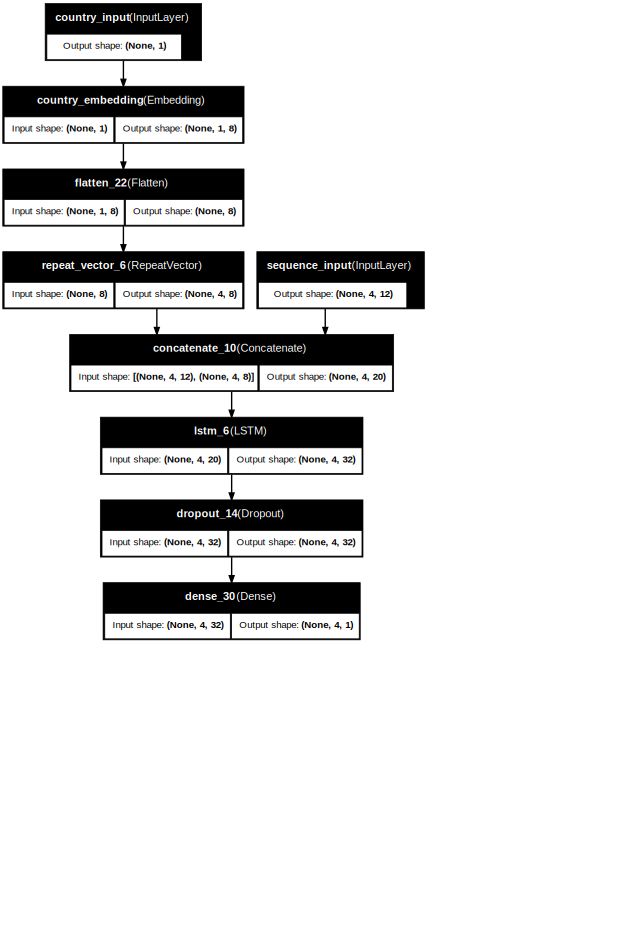

Epoch 1/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0011 - mse: 0.0011 - val_loss: 2.9188e-04 - val_mse: 2.9188e-04 - learning_rate: 0.0010
Epoch 2/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.8804e-04 - mse: 8.8804e-04 - val_loss: 2.7956e-04 - val_mse: 2.7956e-04 - learning_rate: 0.0010
Epoch 3/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 8.2342e-04 - mse: 8.2342e-04 - val_loss: 2.7353e-04 - val_mse: 2.7353e-04 - learning_rate: 0.0010
Epoch 4/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 8.1163e-04 - mse: 8.1163e-04 - val_loss: 2.6883e-04 - val_mse: 2.6883e-04 - learning_rate: 0.0010
Epoch 5/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.8272e-04 - mse: 7.8272e-04 - val_loss: 2.6640e-04 - val_mse: 2.6640e-04 - learning_rate: 0.0010
Epoch 6/20
91/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.8471e-04 - mse: 6.8471e-04
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.8880e-04 - mse:

In [ ]:
model = create_lstm_baseline(
    input_sequence_length=4,
    output_sequence_length=4,
    num_countries=len(np.unique(train_data['static_features'])),
    num_features=12
)

# Prepare data encodings
label_encoder = LabelEncoder()
train_static_encoded = label_encoder.fit_transform(train_data['static_features'])
val_static_encoded = label_encoder.transform(val_data['static_features'])

# Convert sequences with proper type casting
X_train_seq = np.asarray(train_data['trend_sequences']).astype(np.float32)
X_val_seq = np.asarray(val_data['trend_sequences']).astype(np.float32)
X_train_temporal = np.asarray(train_data['temporal_sequences']).astype(np.float32)
X_val_temporal = np.asarray(val_data['temporal_sequences']).astype(np.float32)

# Define callbacks with proper monitoring strategy
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,  # Important for best model preservation
        mode='min'
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-6,
        mode='min',
        verbose=1
    )
]

# Training setup
history = model.fit(
    [X_train_seq, train_static_encoded],
    train_data['output_sequences'].astype(np.float32),
    validation_data=(
        [X_val_seq, val_static_encoded],
        val_data['output_sequences'].astype(np.float32)
    ),
    epochs=20,
    callbacks=callbacks,
    verbose=1,
)

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
{'mae': 0.030748555, 'rmse': 0.26036707, 'r2': 0.544254869222641, 'smape': 48.63264858722687}

Mutual Gini: 0.1302 (lower is better)


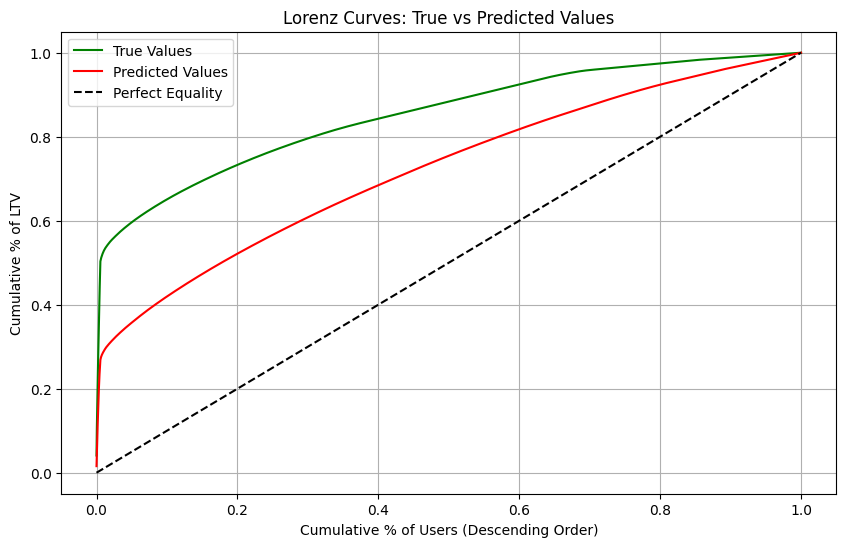

In [ ]:
predictions = predict_customer_ltv(
    model,
    test_data,
    train_data,
    label_encoder,
    model_type ="LSTM"
)
predictions = tf.squeeze(predictions)

# Calculate basic metrics
metrics = calculate_metrics(test_data['output_sequences'], predictions)
print(metrics)
# Plot Lorenz curves and get Mutual Gini
mutual_gini = plot_lorenz_analysis(test_data['output_sequences'], predictions)


# Hybrid Transformer / LSTM model architecture

The architecture follows key principles established in recent literature:

+ Uses Bidirectional LSTMs for sequential data processing, as documented by Petnehází in their framework for RNN-based time series forecasting

+ Incorporates Transformer elements, following the evolution of sequence models that moved beyond traditional CNN and RNN architectures, as introduced by Vaswani et al. in 2017

+ Addresses both short and long-term dependencies through its attention mechanisms, which is particularly attractive for time series modeling as it can capture long-range dependencies and interactions


The hybrid nature of this model is particularly significant because it combines RNN's ability to handle sequential data with Transformer's self-attention mechanisms, which have shown superior performance

In [ ]:
def build_hybrid_forecaster_transformer(
    input_sequence_length: int,
    output_sequence_length: int,
    num_countries: int,
    d_model: int = 16,
    num_heads: int = 4
):
    """
    Builds a hybrid Transformer-LSTM model for time series forecasting.

    Args:
        input_sequence_length: Length of input sequences
        output_sequence_length: Length of prediction sequence
        num_countries: Number of unique countries for embedding
        d_model: Dimension of the model's latent space
        num_heads: Number of attention heads

    Returns:
        Compiled Keras model
    """


    # Set seeds for reproducibility
    set_seeds(seed=42)

    # Input Blocks
    temporal_inputs = Input(shape=(input_sequence_length, 5))
    trend_inputs = Input(shape=(input_sequence_length, 12))
    country_inputs = Input(shape=(1,), dtype="int32")

    # Embedding and Projection
    country_embedding = Embedding(input_dim=num_countries, output_dim=d_model)(country_inputs)
    country_embedding = Flatten()(country_embedding)
    country_embedding_repeated = RepeatVector(input_sequence_length)(country_embedding)

    # Temporal processing branch
    temporal_projection = Dense(d_model)(temporal_inputs)

    # Combine features
    combined_features = Add()([temporal_projection, country_embedding_repeated])

    # Transformer stack
    transformer_output = combined_features
    for _ in range(6):
        transformer_output = TransformerEncoder(
            num_heads=num_heads,
            intermediate_dim = 4
        )(transformer_output)

    # LSTM for trend processing
    lstm_output = Bidirectional(LSTM(units=64))(trend_inputs)

    # Merge representations
    merged_features = Concatenate()([
        GlobalAveragePooling1D()(transformer_output),
        lstm_output
    ])

    # Decoder modified with Bidirectional LSTM
    decoder_initial = RepeatVector(output_sequence_length)(merged_features)
    decoder_lstm = Bidirectional(LSTM(64, return_sequences=True))(decoder_initial)
    output = Dense(1)(decoder_lstm)

    # Build model
    model = Model(
        inputs=[temporal_inputs, trend_inputs, country_inputs],
        outputs=output
    )

    # Visualization
    dot_rep = model_to_dot(
        model,
        show_shapes=True,
        show_layer_names=True,
        rankdir='TB',
        dpi=50
    ).to_string()
    display(Source(dot_rep))

    # Compile with standard optimizer and loss
    model.compile(optimizer='adam', loss='mse')

    return model

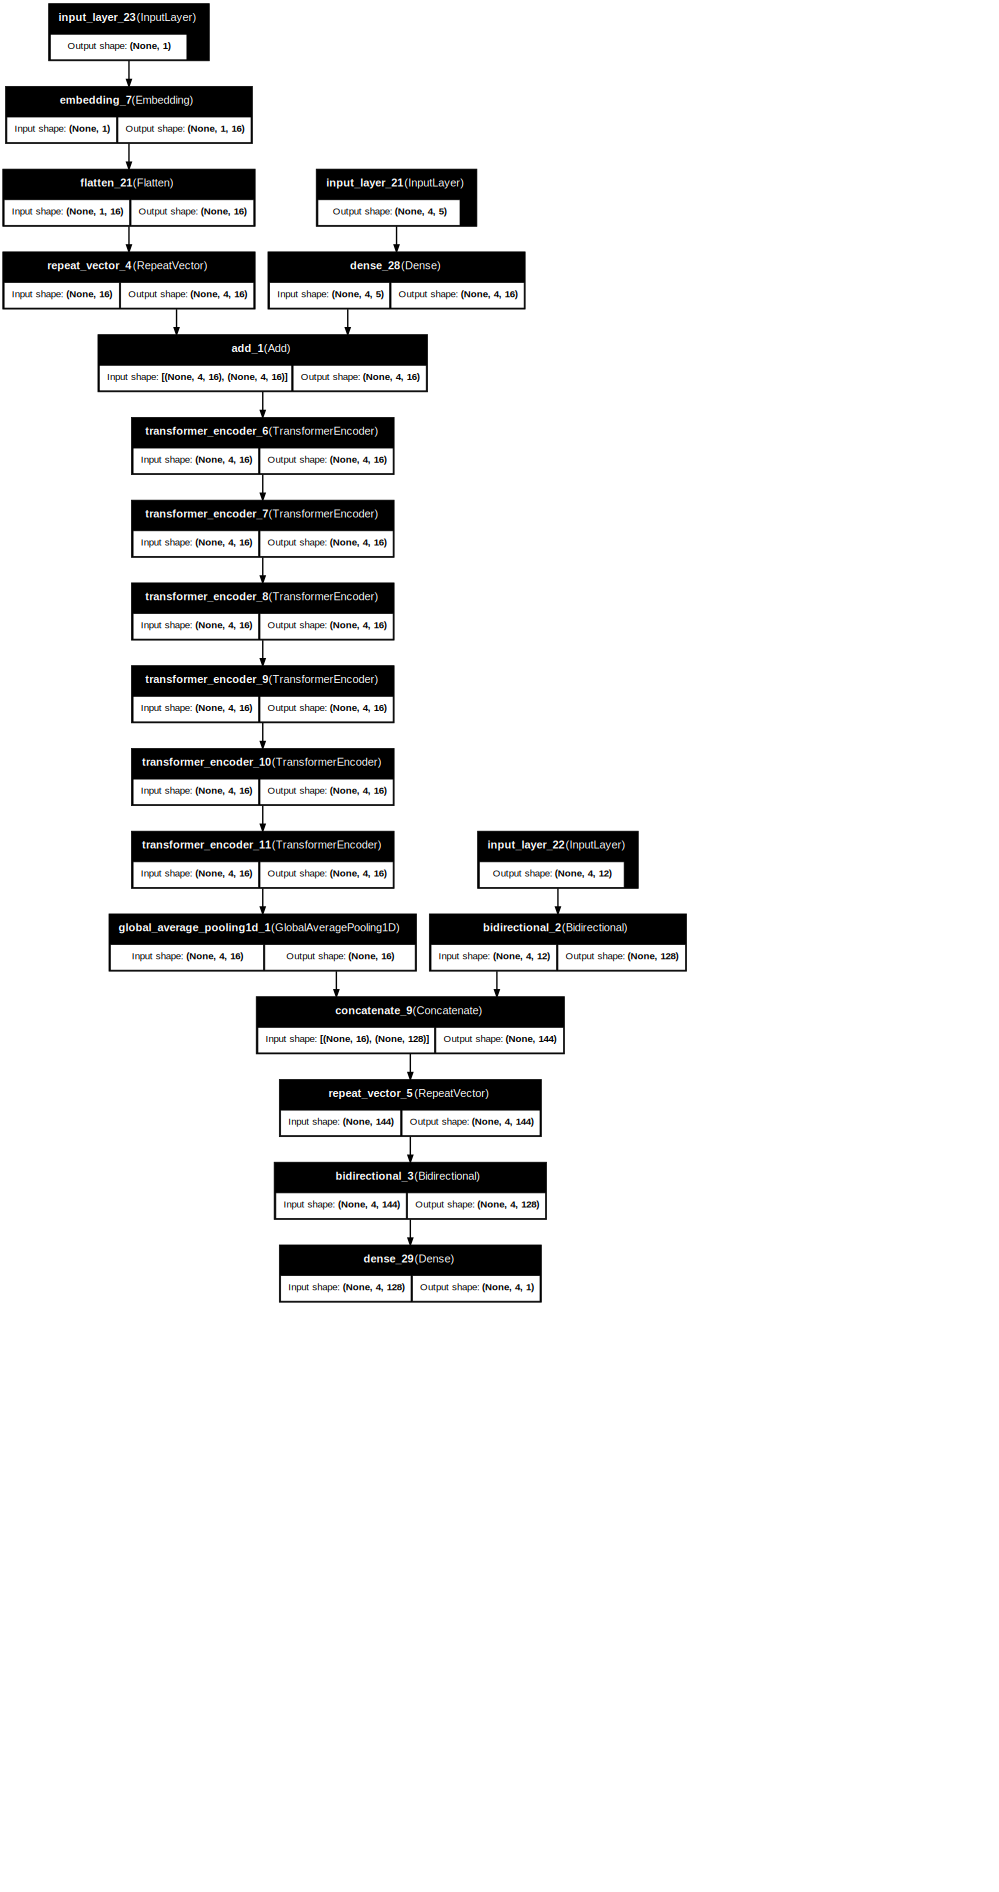

Epoch 1/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 38s 109ms/step - loss: 0.0068 - val_loss: 2.7654e-04 - learning_rate: 0.0010
Epoch 2/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - loss: 6.3556e-04 - val_loss: 3.6279e-04 - learning_rate: 0.0010
Epoch 3/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 6.0473e-04 - val_loss: 3.0754e-04 - learning_rate: 0.0010
Epoch 4/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - loss: 5.7348e-04 - val_loss: 2.7391e-04 - learning_rate: 0.0010
Epoch 5/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 5.4852e-04 - val_loss: 3.0244e-04 - learning_rate: 0.0010
Epoch 6/20
97/98 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 5.5355e-04
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 5.5422e-04 - val_loss: 3.9447e-04 - learning_rate: 0.0010
Epoch 7/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 5.3122e-04 - val_loss: 2.4206e-04 - learning_rate: 2.0000e-04
Epoch 8/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 3

In [ ]:
# Create the hybrid model
model = build_hybrid_forecaster_transformer(
    input_sequence_length=4,
    output_sequence_length=4,
    num_countries=len(np.unique(train_data['static_features'])),
    d_model=16,
    num_heads=4
)

# Prepare data encodings
label_encoder = LabelEncoder()
train_static_encoded = label_encoder.fit_transform(train_data['static_features'])
val_static_encoded = label_encoder.transform(val_data['static_features'])

# Convert sequences with proper type casting
X_train_seq = np.asarray(train_data['trend_sequences']).astype(np.float32)
X_val_seq = np.asarray(val_data['trend_sequences']).astype(np.float32)
X_train_temporal = np.asarray(train_data['temporal_sequences']).astype(np.float32)
X_val_temporal = np.asarray(val_data['temporal_sequences']).astype(np.float32)

# Define callbacks with proper monitoring strategy
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,  # Important for best model preservation
        mode='min'
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-6,
        mode='min',
        verbose=1
    )
]

# Training setup
history = model.fit(
    [X_train_temporal,X_train_seq, train_static_encoded],
    train_data['output_sequences'].astype(np.float32),
    validation_data=(
        [X_val_temporal,X_val_seq, val_static_encoded],
        val_data['output_sequences'].astype(np.float32)
    ),
    epochs=20,
    callbacks=callbacks,
    verbose=1,
)

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
{'mae': 0.019729413, 'rmse': 0.15545744, 'r2': 0.8375300914049149, 'smape': 43.28555464744568}

Mutual Gini: 0.0633 (lower is better)


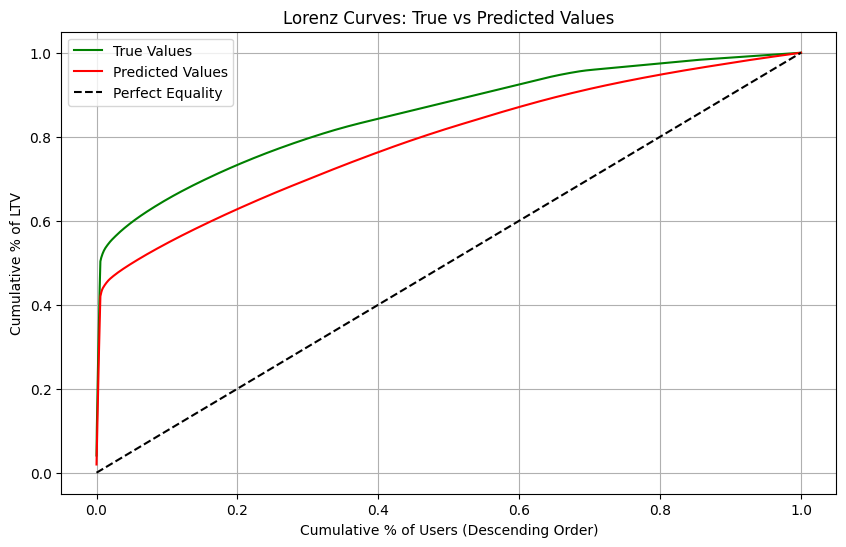

In [ ]:
# Calculate the predictions
predictions = predict_customer_ltv(
    model,
    test_data,
    train_data,
    label_encoder
)
predictions = tf.squeeze(predictions)

# Calculate basic metrics
hybrid_metrics = calculate_metrics(test_data['output_sequences'], predictions)
print(metrics)
# Plot Lorenz curves and get Mutual Gini
hybrid_mutual_gini = plot_lorenz_analysis(test_data['output_sequences'], predictions)

# Evaluation comparison of models

In [ ]:

final_evaluation = pd.DataFrame({
    'Model Type': ['LSTM', 'Hybrid'],
    'RMSE': [metrics['rmse'], hybrid_metrics['rmse']],
    'R2': [metrics['r2'], hybrid_metrics['r2']],
    'MAE': [metrics['mae'], hybrid_metrics['mae']],
    'Mutual Gini': [mutual_gini, hybrid_mutual_gini],

})

# Format the table with reasonable decimal places
final_evaluation = final_evaluation.round(4)

# Display the styled table
display(final_evaluation)

,Model Type,RMSE,R2,MAE,Mutual Gini
0,LSTM,0.2604,0.5443,0.0307,0.1302
1,Hybrid,0.1555,0.8375,0.0197,0.0633


Conclusion: While LSTMs provide a solid baseline for capturing sequential patterns, the hybrid approach's additional attention mechanisms allow it to adaptively focus on the most relevant temporal/seasonal features for prediction.